Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**IMPORTING SKIN CANCER DATA**

In [ ]:
#importing all important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#defining the path for train and test images
data_dir_train = pathlib.Path( root_path + "Train" )
data_dir_test = pathlib.Path( root_path + "Test" )

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


keras.preprocessing

creating a dataset and defining some parameter for the loader

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of images for training and 20% for validation

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,                       
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


VISUALIZE THE DATA

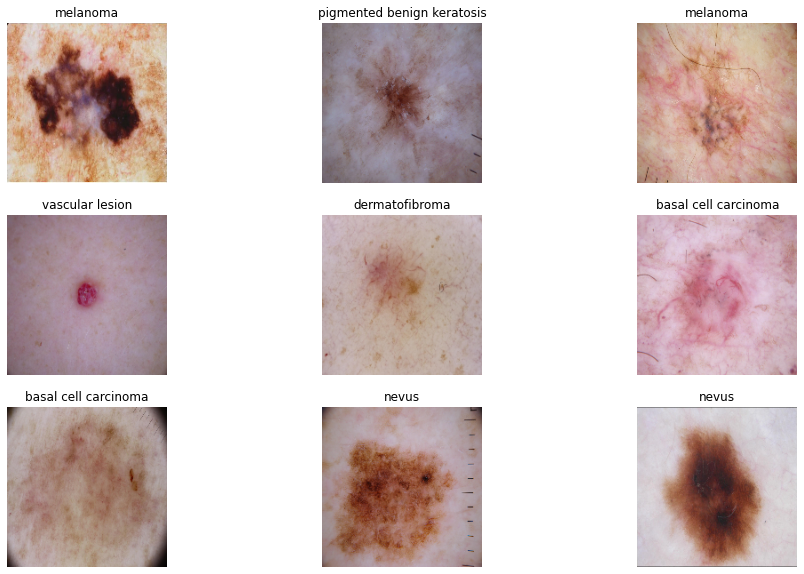

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

CREATE THE MODEL

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0042976383 0.87879103


MODEL 1

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

COMPILE THE MODEL

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

There are total 3,989,801 parameters which all are trainable.

TRAIN THE MODEL

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 98s 2s/step - loss: 1.9964 - accuracy: 0.2455 - val_loss: 1.8967 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 79s 1s/step - loss: 1.8052 - accuracy: 0.3465 - val_loss: 1.6683 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 78s 1s/step - loss: 1.5549 - accuracy: 0.4732 - val_loss: 1.4701 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 87s 2s/step - loss: 1.4060 - accuracy: 0.5128 - val_loss: 1.3713 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 77s 1s/step - loss: 1.3322 - accuracy: 0.5296 - val_loss: 1.3804 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 80s 1s/step - loss: 1.2081 - accuracy: 0.5759 - val_loss: 1.4162 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 79s 1s/step - loss: 1.1704 - accuracy: 0.5932 - val_loss: 1.3457 - val_accuracy: 0.5481
Epoch 8/20
56/56 [==

VISUALIZING TRAINING RESULTS

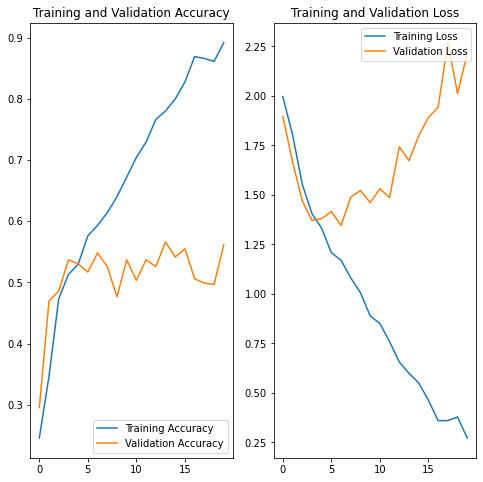

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

OBSERVATION/FINDING:

1) Accuracy of model is around 80% and validation is around 50%

2) Since validation accuracy is much lower/differ from train dataset it is a sign of overfitting

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

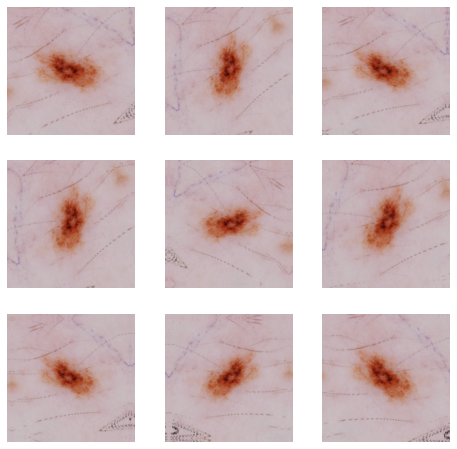

In [ ]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

CREATE MODEL, COMPILE & TRAIN THE MODEL

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

TRAINING THE MODEL

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 98s 2s/step - loss: 2.0934 - accuracy: 0.1998 - val_loss: 1.9836 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - 92s 2s/step - loss: 1.9105 - accuracy: 0.2879 - val_loss: 1.7827 - val_accuracy: 0.3535
Epoch 3/20
56/56 [==============================] - 92s 2s/step - loss: 1.6716 - accuracy: 0.4001 - val_loss: 1.6112 - val_accuracy: 0.4362
Epoch 4/20
56/56 [==============================] - 91s 2s/step - loss: 1.4947 - accuracy: 0.4676 - val_loss: 1.4369 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 89s 2s/step - loss: 1.4262 - accuracy: 0.4877 - val_loss: 1.4360 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 92s 2s/step - loss: 1.3619 - accuracy: 0.5145 - val_loss: 1.3862 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 96s 2s/step - loss: 1.3170 - accuracy: 0.5368 - val_loss: 1.6270 - val_accuracy: 0.4855
Epoch 8/20
56/56 [=============

VISUALIZING THE RESULTS

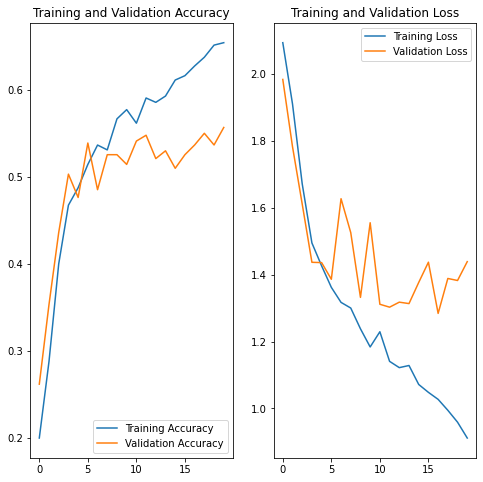

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Finding/Observations

1) There is sudden drop in accuracy of train data set that is from around 80% to around 60%.

2) Accuracy for validation data set in around 60%.

3) Both the train and validation accuracy values are not differ by large number and hence it shows that the overfitting of model is reduce at great extent.

                        Class Count
0           actinic keratosis   114
1        basal cell carcinoma   376
2              dermatofibroma    95
3                    melanoma   438
4                       nevus   357
5  pigmented benign keratosis   462
6        seborrheic keratosis    77
7     squamous cell carcinoma   181
8             vascular lesion   139


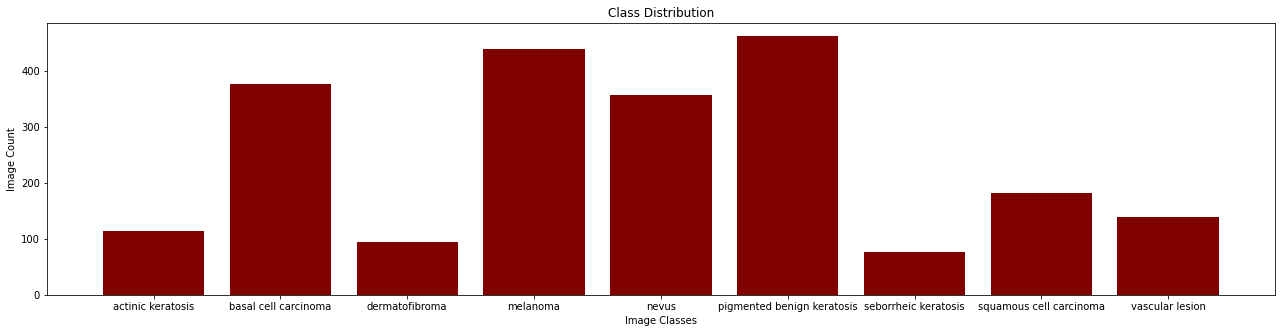

In [ ]:
distributionDs = pd.DataFrame(columns=['Class','Count'])
for sub in class_names:
  imgCount = len(list(data_dir_train.glob(sub+'/*.jpg')))
  distributionDs = distributionDs.append({'Class':sub, 'Count':imgCount}, ignore_index=True)

print(distributionDs.head(10))

fig = plt.figure(figsize = (22, 5))
# creating the bar plot to see distribution
plt.bar(distributionDs.Class, distributionDs.Count, color ='maroon',width = 0.8)
 
plt.xlabel("Image Classes")
plt.ylabel("Image Count")
plt.title("Class Distribution")
plt.show()

Findings

1) seborrheic keratosis have least number of samples.

2) Following are the classes which dominates the data most in terms of proportionate number of samples:
    i) pigmented benign keratosis
    ii) melanoma
    iii) basal cell carcinoma
    iv) nevus

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset= root_path+"Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F38A71AC5B0>: 100%|██████████| 500/500 [00:36<00:00, 13.60 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F38A7107E50>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F38A717DBB0>: 100%|██████████| 500/500 [00:36<00:00, 13.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F38B44509D0>: 100%|██████████| 500/500 [02:33<00:00,  3.26 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F38A4AB2400>: 100%|██████████| 500/500 [02:09<00:00,  3.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F38A4124D00>: 100%|██████████| 500/500 [00:32<00:00, 15.18 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F38B45687C0>: 100%|██████████| 500/500 [01:06<00:00,  7.47 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F38A715D8B0>: 100%|██████████| 500/500 [00:34<00:00, 14.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F38A7E910D0>: 100%|██████████| 500/500 [00:33<00:00, 14.90 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Let's see the distribution of augmented data after adding new images to the original training data

In [ ]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
len(path_list)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
len(lesion_list_new)

4500

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

                        Class Count
0           actinic keratosis   614
1        basal cell carcinoma   876
2              dermatofibroma   595
3                    melanoma   938
4                       nevus   857
5  pigmented benign keratosis   962
6        seborrheic keratosis   577
7     squamous cell carcinoma   681
8             vascular lesion   639


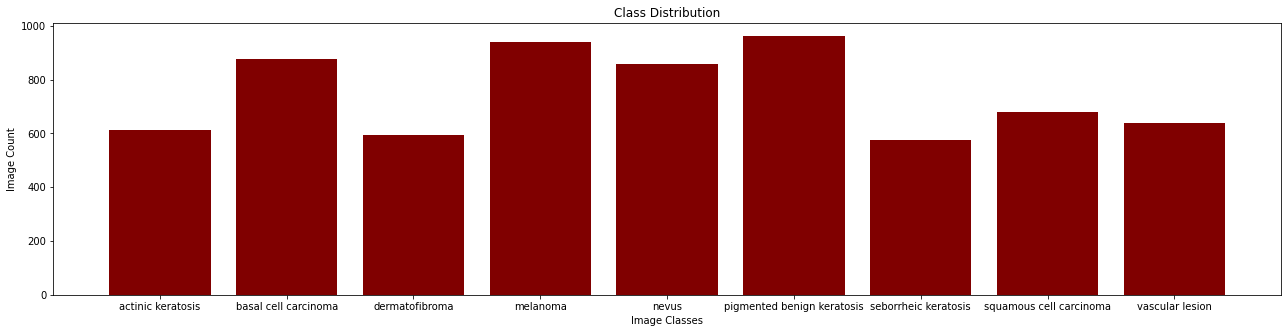

In [ ]:
newDistributionDs = pd.DataFrame(columns=['Class','Count'])
for i in class_names:
    directory =root_path +"Train/"+i+'/'
    directory_out =root_path+"Train/"+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    newDistributionDs = newDistributionDs.append({'Class':i, 'Count':length_tot}, ignore_index=True)

print(newDistributionDs.head(10))

fig = plt.figure(figsize = (22, 5))
# creating the bar plot to see distribution
plt.bar(newDistributionDs.Class, newDistributionDs.Count, color ='maroon',width = 0.8)
 
plt.xlabel("Image Classes")
plt.ylabel("Image Count")
plt.title("Class Distribution")
plt.show()

TRAINING THE MODEL ON THE DATA CREATED USING AUGMENTOR

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train=root_path+"Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
model_final=Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),
    layers.Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),   
    layers.Dense(9, activation='softmax')
])

In [ ]:
model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 30
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 569s 3s/step - loss: 2.8315 - accuracy: 0.1630 - val_loss: 2.0079 - val_accuracy: 0.2598
Epoch 2/30
169/169 [==============================] - 536s 3s/step - loss: 1.8408 - accuracy: 0.2888 - val_loss: 1.7429 - val_accuracy: 0.3593
Epoch 3/30
169/169 [==============================] - 520s 3s/step - loss: 1.6989 - accuracy: 0.3535 - val_loss: 1.5419 - val_accuracy: 0.4380
Epoch 4/30
169/169 [==============================] - 519s 3s/step - loss: 1.5360 - accuracy: 0.4228 - val_loss: 1.4157 - val_accuracy: 0.4885
Epoch 5/30
169/169 [==============================] - 554s 3s/step - loss: 1.4114 - accuracy: 0.4729 - val_loss: 1.2859 - val_accuracy: 0.5427
Epoch 6/30
169/169 [==============================] - 541s 3s/step - loss: 1.3441 - accuracy: 0.4887 - val_loss: 1.2745 - val_accuracy: 0.5501
Epoch 7/30
169/169 [==============================] - 552s 3s/step - loss: 1.2586 - accuracy: 0.5313 - val_loss: 1.1981 - val_accuracy: 0.5991
Epoch 8/30

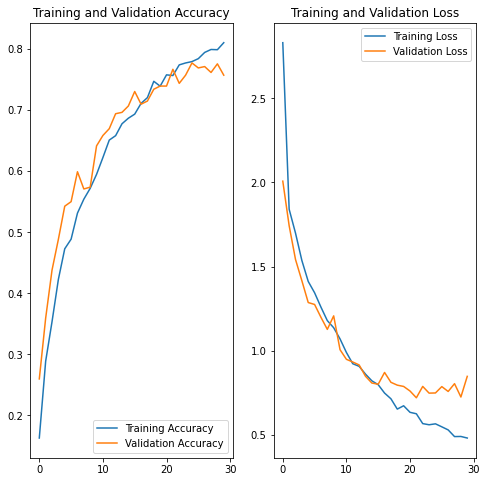

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

OBSERVATIONS:

1) Accuracies on train and validation datasets after class rebalance are around 80% and 70% respectively.

2) Training model on rebalanced dataset just increase the accuracy to some extent but does not help in overfitting/underfitting

PREDICTIONS ON UNSEEN DATA

In [ ]:
# making Predictions on some of test data images
testImgList = list(data_dir_test.glob('*/*.jpg'))
imageArray = []
for i in range(0,20):
  imageArray.append(tf.keras.utils.load_img(testImgList[i], target_size=(img_height, img_width)))

for j in imageArray:
  img_array = tf.keras.utils.img_to_array(j)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to    {}    with a    {:.2f}%   confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 1s 905ms/step
This image most likely belongs to    basal cell carcinoma    with a    33.37%   confidence.
1/1 [==============================] - 0s 56ms/step
This image most likely belongs to    vascular lesion    with a    99.92%   confidence.
1/1 [==============================] - 0s 46ms/step
This image most likely belongs to    vascular lesion    with a    100.00%   confidence.
1/1 [==============================] - 0s 48ms/step
This image most likely belongs to    basal cell carcinoma    with a    30.99%   confidence.
1/1 [==============================] - 0s 52ms/step
This image most likely belongs to    nevus    with a    45.93%   confidence.
1/1 [==============================] - 0s 58ms/step
This image most likely belongs to    nevus    with a    45.46%   confidence.
1/1 [==============================] - 0s 48ms/step
This image most likely belongs to    squamous cell carcinoma    with a    55.46%   confidence.
1/1 [======================

OBSERAVTIONS

The class rebalance helped in reducing overfititng of the data and thus the loss is being reduced, but the reduced acurracy is very low

Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

Then we introduced dropout and ImageDataGenerator which reduced the over fit

At last we tried Batch Normalization and Augumentation which really helped in carry forward